<a href="https://colab.research.google.com/github/ZeroToH3ro/Predictive-Model-Advance/blob/main/Predictive_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as FDA
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
def sequence_to_features(seq, seq_type='dna', daas=None):
    """
    seq_type='dna' will apply the DNA mapping,
    seq_type='aa'  will apply the amino acid mapping.
    daas is 1 if the medicine is used, else 0.
    """
    # DNA base mapping
    base_dict = {
        'A': 1, 'C': 2, 'G': 3, 'T': 4,
        'N': 0, '-': 0,
        'R': 5, 'Y': 6, 'M': 7, 'K': 8,
        'S': 9, 'W': 10, 'H': 11, 'B': 12,
        'V': 13, 'D': 14
    }

    # Amino acid mapping
    aa_dict = {
        'A': 1, 'R': 2, 'N': 3, 'D': 4, 'C': 5,
        'Q': 6, 'E': 7, 'G': 8, 'H': 9, 'I': 10,
        'L': 11, 'K': 12, 'M': 13, 'F': 14, 'P': 15,
        'S': 16, 'T': 17, 'W': 18, 'Y': 19, 'V': 20,
        '-': 0, 'X': 0
    }

    features = []
    if seq_type == 'dna':
        features = [base_dict.get(base, 0) for base in seq]
    elif seq_type == 'aa':
        features = [aa_dict.get(aa, 0) for aa in seq]
    else:
        raise ValueError("seq_type must be either 'dna' or 'aa'")

    # Include DAAS (medicine) as a binary feature if provided
    if daas is not None:
        features.append(int(daas))  # 1 if True, else 0

    return features

In [3]:
def prepare_data_nucleotide(data_path):
    # Load dataset
    data = pd.read_excel(data_path)

    # Build feature matrix X using Nucleotide + DAAS
    X_list = []
    for idx, row in data.iterrows():
        nucleotide_seq = str(row['Nucleotide']) if pd.notna(row['Nucleotide']) else ''
        # Convert the DAAS column to 1 if not empty (or if the user took the medicine)
        daas_value = row['DAAS'] if 'DAAS' in data.columns else None

        # Create features
        features = sequence_to_features(
            seq=nucleotide_seq,
            seq_type='dna',
            daas=daas_value
        )
        X_list.append(features)

    # Convert list of lists into a 2D numpy array
    X = np.array(X_list, dtype=float)

    # Target vector y from "Respond"
    # Modified to map specific values, check for potential issues
    # For example, 'Yes'/'No' mapping. Adjust as per your data
    y = data['Respond'].map({'Yes': 1, 'No': 0}).values

    # Add a check for unique values in y:
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        raise ValueError(f"Target variable 'Respond' has only {len(unique_classes)} unique class(es): {unique_classes}. "
                         f"At least two classes are needed for classification.")

    return X, y

In [4]:
def prepare_data_amino(data_path):
    # Load dataset
    data = pd.read_excel(data_path)

    # Build feature matrix X using Amino_Acid + DAAS
    X_list = []
    for idx, row in data.iterrows():
        aa_seq = str(row['Amino_Acid']) if pd.notna(row['Amino_Acid']) else ''
        daas_value = row['DAAS'] if 'DAAS' in data.columns else None

        # Create features
        features = sequence_to_features(
            seq=aa_seq,
            seq_type='aa',
            daas=daas_value
        )
        X_list.append(features)

    X = np.array(X_list, dtype=float)

    # Target vector y from "Respond"
    y = data['Respond'].map({'Yes': 1, 'No': 0}).values # Assume your data has 'Yes' and 'No' values.

    # Add a check for unique values in y:
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        raise ValueError(f"Target variable 'Respond' has only {len(unique_classes)} unique class(es): {unique_classes}. "
                         f"At least two classes are needed for classification.")

    return X, y

In [11]:
def plot_model_comparison(results):
    """
    Create visualizations comparing model performance
    """
    # Accuracy comparison
    plt.figure(figsize=(12, 6))
    accuracies = {name: res['accuracy'] for name, res in results.items()}
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.ylabel('Accuracy')
    plt.tight_layout()
    plt.show()

    # ROC curves
    plt.figure(figsize=(12, 6))
    for name, res in results.items():
        # Get the stored fpr, tpr values directly
        fpr = res['roc_curve'][0]  # First element is fpr
        tpr = res['roc_curve'][1]  # Second element is tpr
        auc_score = res['auc']     # Get the pre-calculated AUC score

        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')  # Add diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for Different Models')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [12]:
def optimize_models(X_train_scaled, y_train):
    """
    Optimize hyperparameters for all models using GridSearchCV
    """
    optimized_models = {}

    # SVM optimization
    svm_params = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'kernel': ['rbf', 'linear', 'poly'],
        'class_weight': ['balanced', None]
    }
    svm = GridSearchCV(SVC(probability=True, random_state=42), svm_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Neural Network optimization
    nn_params = {
        'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],
        'activation': ['relu', 'tanh'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive'],
        'max_iter': [2000]
    }
    nn = GridSearchCV(MLPClassifier(random_state=42), nn_params, cv=5, scoring='accuracy', n_jobs=-1)

    # KNN optimization
    knn_params = {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree']
    }
    knn = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Logistic Regression optimization
    lr_params = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'class_weight': ['balanced', None]
    }
    lr = GridSearchCV(LogisticRegression(random_state=42, max_iter=2000), lr_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Random Forest optimization
    rf_params = {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': ['balanced', 'balanced_subsample', None]
    }
    rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=5, scoring='accuracy', n_jobs=-1)

    # FDA optimization
    fda_params = {
        'solver': ['svd', 'lsqr', 'eigen'],
        'shrinkage': [None, 'auto'],
        'store_covariance': [True, False]
    }
    # fda = GridSearchCV(LinearDiscriminantAnalysis(), fda_params, cv=5, scoring='accuracy', n_jobs=-1)
    fda = LinearDiscriminantAnalysis()
    # GBM optimization
    gbm_params = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'subsample': [0.8, 0.9, 1.0]
    }
    gbm = GridSearchCV(GradientBoostingClassifier(random_state=42), gbm_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Decision Tree optimization
    dt_params = {
        'max_depth': [3, 5, 7, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'criterion': ['gini', 'entropy']
    }
    dt = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=5, scoring='accuracy', n_jobs=-1)

    # Naive Bayes optimization
    nb = GaussianNB()

    models = {
        'SVM': svm,
        'Neural Network': nn,
        'KNN': knn,
        'Logistic Regression': lr,
        'Random Forest': rf,
        'FDA': fda,
        'GBM': gbm,
        'Decision Tree': dt,
        'Naive Bayes': nb
    }

    # Fit all models
    for name, model in models.items():
        print(f"Optimizing {name}...")
        model.fit(X_train_scaled, y_train)
        if hasattr(model, 'best_estimator_'):
            optimized_models[name] = model.best_estimator_
            print(f"Best parameters for {name}: {model.best_params_}")
            print(f"Best cross-validation score: {model.best_score_:.4f}\n")
        else:
            optimized_models[name] = model
            cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
            print(f"Cross-validation scores for {name}: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})\n")

    return optimized_models

In [13]:
# In your train_and_evaluate_models function:
def train_and_evaluate_models(X, y, label=''):
    print("Data of label:  ", label)
    # Split data with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Get optimized models
    models = optimize_models(X_train_scaled, y_train)

    results = {}
    for name, model in models.items():
        # Train and predict
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        report = classification_report(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        auc_score = auc(fpr, tpr)

        # Store results
        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'roc_curve': (fpr, tpr),
            'auc': auc_score
        }

        print(f"\nResults for {name}:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"AUC Score: {auc_score:.4f}")
        print("Classification Report:")
        print(report)
        pd.DataFrame(X_train).to_excel(f'{name}_train.xlsx', index=False)
        pd.DataFrame(X_test).to_excel(f'{name}_test.xlsx', index=False)

    # Plot comparisons
    plot_model_comparison(results)

    return results

Data of label:   Nucleotide
Optimizing SVM...
Best parameters for SVM: {'C': 1, 'class_weight': 'balanced', 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.8875

Optimizing Neural Network...
Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 2000}
Best cross-validation score: 0.7875

Optimizing KNN...
Best parameters for KNN: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
Best cross-validation score: 0.8750

Optimizing Logistic Regression...
Best parameters for Logistic Regression: {'C': 10, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8750

Optimizing Random Forest...
Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score: 0.8875

Optimizing FDA...
Cross-validation 

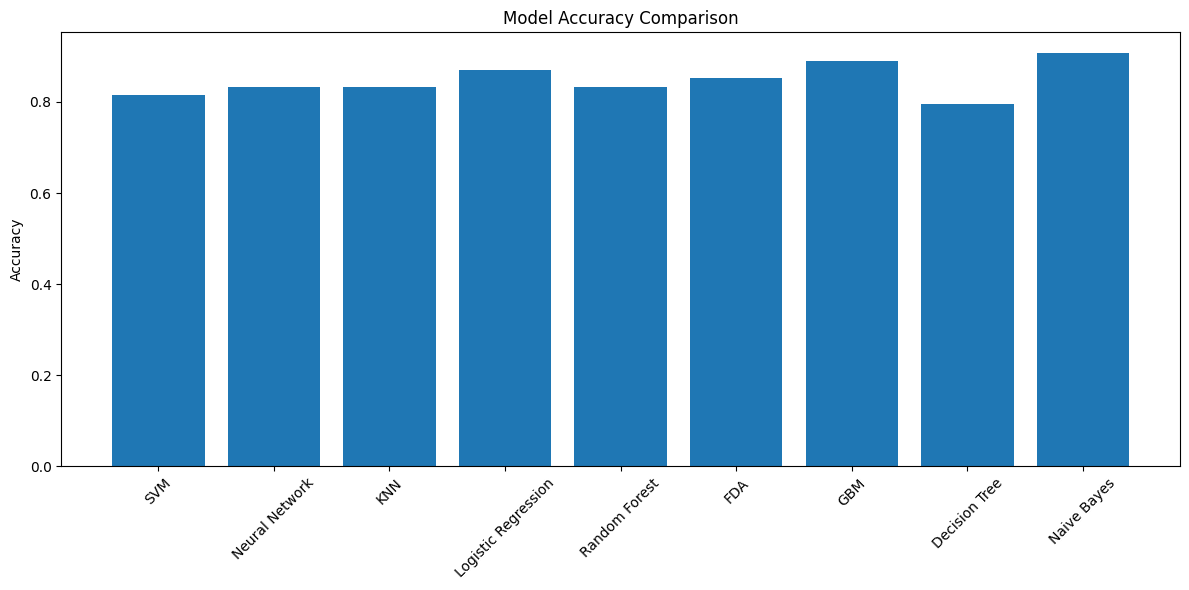

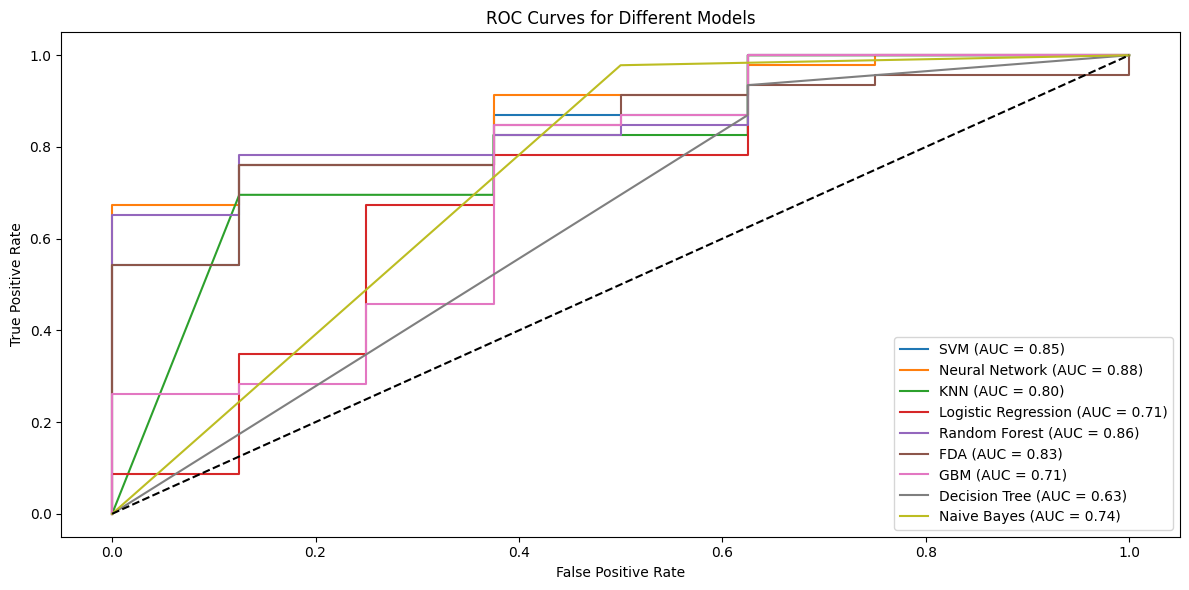

Data of label:   Amino_Acid
Optimizing SVM...
Best parameters for SVM: {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'poly'}
Best cross-validation score: 0.8750

Optimizing Neural Network...
Best parameters for Neural Network: {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate': 'constant', 'max_iter': 2000}
Best cross-validation score: 0.8375

Optimizing KNN...
Best parameters for KNN: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
Best cross-validation score: 0.8875

Optimizing Logistic Regression...
Best parameters for Logistic Regression: {'C': 1, 'class_weight': None, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.8875

Optimizing Random Forest...
Best parameters for Random Forest: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best cross-validation score: 0.8750

Optimizing FDA...
Cross-validation 

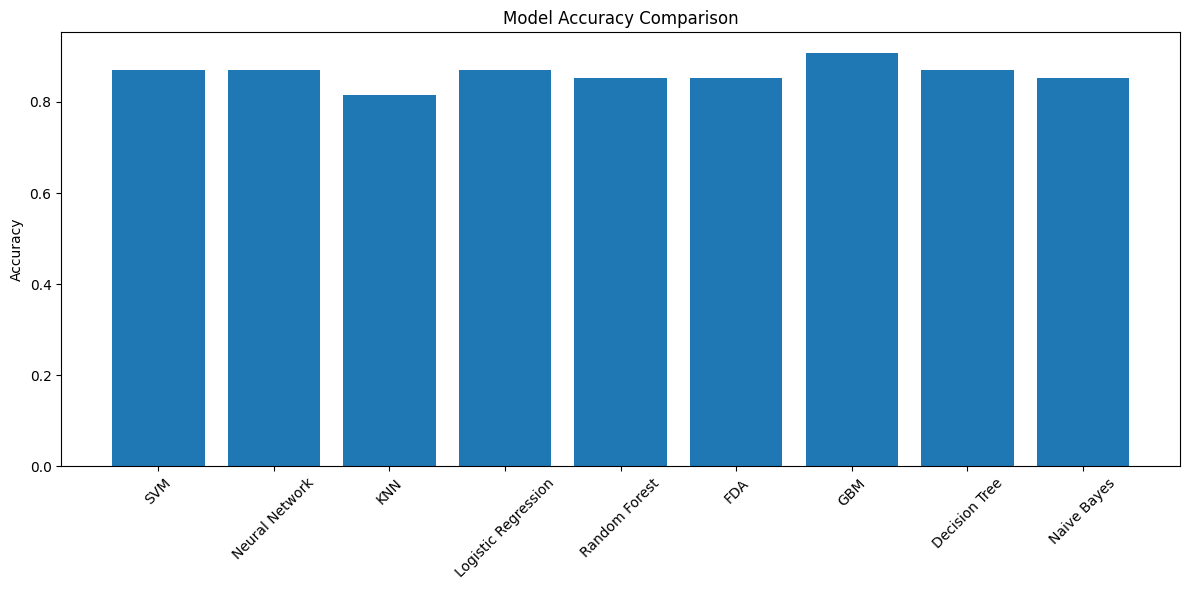

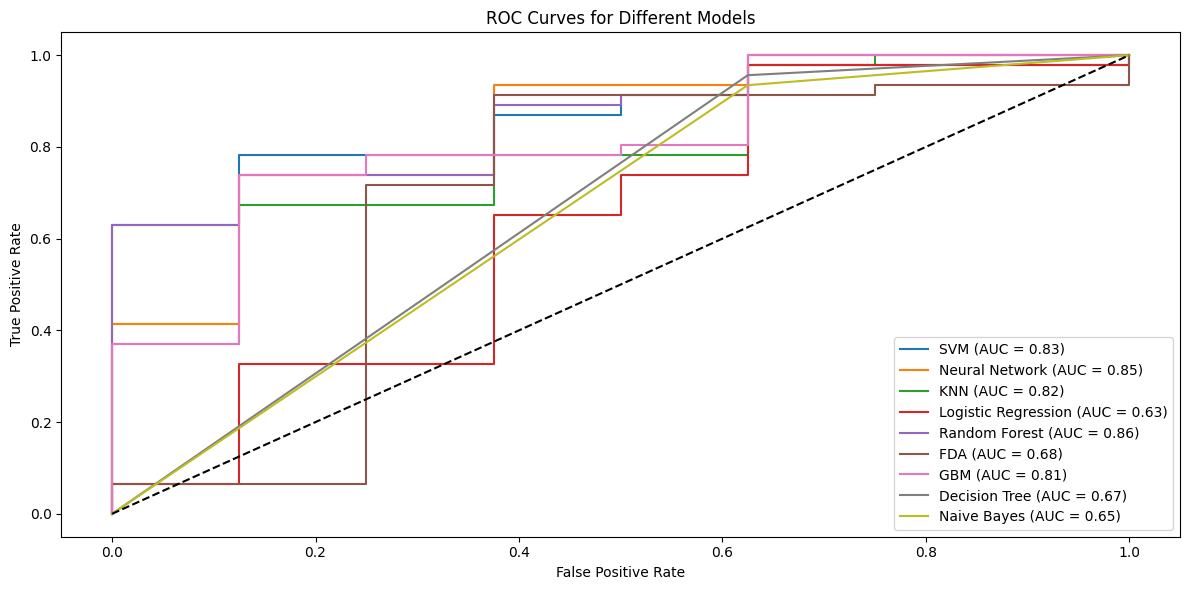

In [14]:
# Path to your actual Excel data
data_path = "sample_data/134-samples-aligned-cutted-Nu-and-a.a-17.12.24.xlsx"

# 1) Prepare Nucleotide-based dataset
X_nu, y_nu = prepare_data_nucleotide(data_path)
results_nu = train_and_evaluate_models(X_nu, y_nu, label='Nucleotide')

# 2) Prepare Amino_Acid-based dataset
X_aa, y_aa = prepare_data_amino(data_path)
results_aa = train_and_evaluate_models(X_aa, y_aa, label='Amino_Acid')